In [1]:
!pip install linearmodels

     ---------------------------------------- 2.0/2.0 MB 7.4 MB/s eta 0:00:00
     ---------------------------------------- 2.8/2.8 MB 9.3 MB/s eta 0:00:00
     ---------------------------------------- 91.0/91.0 kB 5.0 MB/s eta 0:00:00
     ---------------------------------------- 43.8/43.8 kB 2.1 MB/s eta 0:00:00
  Attempting uninstall: Cython
    Found existing installation: Cython 0.29.32
    Uninstalling Cython-0.29.32:
      Successfully uninstalled Cython-0.29.32


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (11, 5)  #set default figure size
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.iolib.summary2 import summary_col
from linearmodels.iv import IV2SLS

In [3]:
df1 = pd.read_stata('https://github.com/QuantEcon/lecture-python/blob/master/source/_static/lecture_specific/ols/maketable1.dta?raw=true')
df1.head()

,shortnam,euro1900,excolony,avexpr,logpgp95,cons1,cons90,democ00a,cons00a,extmort4,logem4,loghjypl,baseco
0,AFG,0.000000,1.0,NaN,NaN,1.0,2.0,1.0,1.0,93.699997,4.540098,NaN,NaN
1,AGO,8.000000,1.0,5.363636,7.770645,3.0,3.0,0.0,1.0,280.000000,5.634789,-3.411248,1.0
2,ARE,0.000000,1.0,7.181818,9.804219,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,ARG,60.000004,1.0,6.386364,9.133459,1.0,6.0,3.0,3.0,68.900002,4.232656,-0.872274,1.0
4,ARM,0.000000,0.0,NaN,7.682482,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


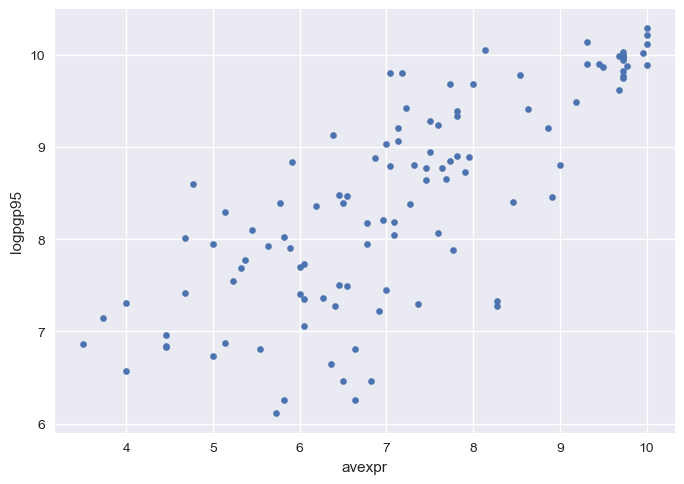

In [4]:
plt.style.use('seaborn')

df1.plot(x='avexpr', y='logpgp95', kind='scatter')
plt.show()

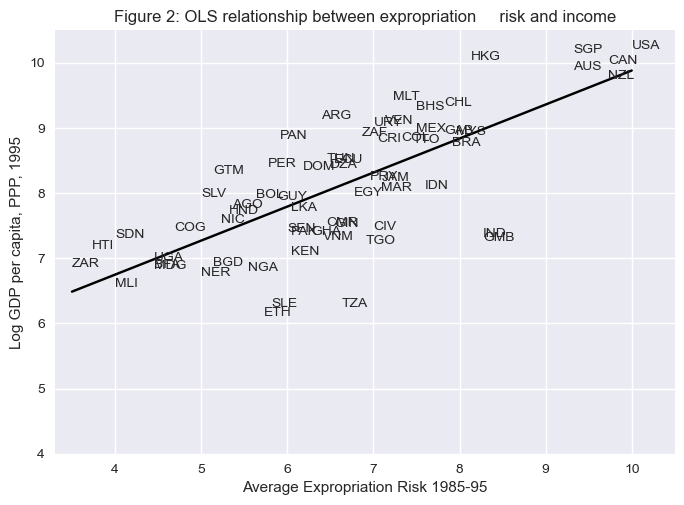

In [5]:
# Dropping NA's is required to use numpy's polyfit
df1_subset = df1.dropna(subset=['logpgp95', 'avexpr'])

# Use only 'base sample' for plotting purposes
df1_subset = df1_subset[df1_subset['baseco'] == 1]

X = df1_subset['avexpr']
y = df1_subset['logpgp95']
labels = df1_subset['shortnam']

# Replace markers with country labels
fig, ax = plt.subplots()
ax.scatter(X, y, marker='')

for i, label in enumerate(labels):
    ax.annotate(label, (X.iloc[i], y.iloc[i]))

# Fit a linear trend line
ax.plot(np.unique(X),
         np.poly1d(np.polyfit(X, y, 1))(np.unique(X)),
         color='black')

ax.set_xlim([3.3,10.5])
ax.set_ylim([4,10.5])
ax.set_xlabel('Average Expropriation Risk 1985-95')
ax.set_ylabel('Log GDP per capita, PPP, 1995')
ax.set_title('Figure 2: OLS relationship between expropriation \
    risk and income')
plt.show()

In [6]:
df1['const'] = 1

In [7]:
reg1 = sm.OLS(endog=df1['logpgp95'], exog=df1[['const', 'avexpr']], \
    missing='drop')
type(reg1)

statsmodels.regression.linear_model.OLS

In [8]:
results = reg1.fit()
type(results)

statsmodels.regression.linear_model.RegressionResultsWrapper

In [9]:
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:               logpgp95   R-squared:                       0.611
Model:                            OLS   Adj. R-squared:                  0.608
Method:                 Least Squares   F-statistic:                     171.4
Date:                Sun, 08 Oct 2023   Prob (F-statistic):           4.16e-24
Time:                        14:28:32   Log-Likelihood:                -119.71
No. Observations:                 111   AIC:                             243.4
Df Residuals:                     109   BIC:                             248.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.6261      0.301     15.391      0.0

In [10]:
mean_expr = np.mean(df1_subset['avexpr'])
mean_expr

6.515625

In [11]:
predicted_logpdp95 = 4.63 + 0.53 * 7.07
predicted_logpdp95

8.3771

In [12]:
results.predict(exog=[1, mean_expr])

array([8.09156367])

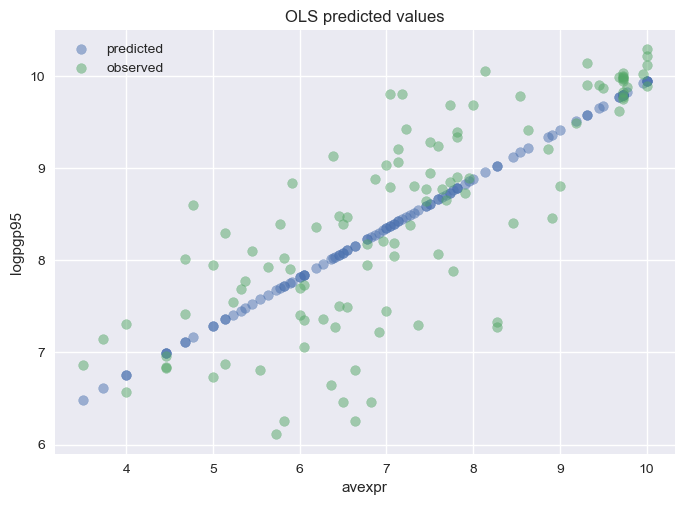

In [13]:
# Drop missing observations from whole sample

df1_plot = df1.dropna(subset=['logpgp95', 'avexpr'])

# Plot predicted values

fix, ax = plt.subplots()
ax.scatter(df1_plot['avexpr'], results.predict(), alpha=0.5,
        label='predicted')

# Plot observed values

ax.scatter(df1_plot['avexpr'], df1_plot['logpgp95'], alpha=0.5,
        label='observed')

ax.legend()
ax.set_title('OLS predicted values')
ax.set_xlabel('avexpr')
ax.set_ylabel('logpgp95')
plt.show()

In [14]:
df2 = pd.read_stata('https://github.com/QuantEcon/lecture-python/blob/master/source/_static/lecture_specific/ols/maketable2.dta?raw=true')

# Add constant term to dataset
df2['const'] = 1

# Create lists of variables to be used in each regression
X1 = ['const', 'avexpr']
X2 = ['const', 'avexpr', 'lat_abst']
X3 = ['const', 'avexpr', 'lat_abst', 'asia', 'africa', 'other']

# Estimate an OLS regression for each set of variables
reg1 = sm.OLS(df2['logpgp95'], df2[X1], missing='drop').fit()
reg2 = sm.OLS(df2['logpgp95'], df2[X2], missing='drop').fit()
reg3 = sm.OLS(df2['logpgp95'], df2[X3], missing='drop').fit()

In [15]:
info_dict={'R-squared' : lambda x: f"{x.rsquared:.2f}",
           'No. observations' : lambda x: f"{int(x.nobs):d}"}

results_table = summary_col(results=[reg1,reg2,reg3],
                            float_format='%0.2f',
                            stars = True,
                            model_names=['Model 1',
                                         'Model 3',
                                         'Model 4'],
                            info_dict=info_dict,
                            regressor_order=['const',
                                             'avexpr',
                                             'lat_abst',
                                             'asia',
                                             'africa'])

results_table.add_title('Table 2 - OLS Regressions')

print(results_table)

        Table 2 - OLS Regressions
                 Model 1 Model 3 Model 4 
-----------------------------------------
const            4.63*** 4.87*** 5.85*** 
                 (0.30)  (0.33)  (0.34)  
avexpr           0.53*** 0.46*** 0.39*** 
                 (0.04)  (0.06)  (0.05)  
lat_abst                 0.87*   0.33    
                         (0.49)  (0.45)  
asia                             -0.15   
                                 (0.15)  
africa                           -0.92***
                                 (0.17)  
other                            0.30    
                                 (0.37)  
R-squared        0.61    0.62    0.72    
R-squared Adj.   0.61    0.62    0.70    
R-squared        0.61    0.62    0.72    
No. observations 111     111     111     
Standard errors in parentheses.
* p<.1, ** p<.05, ***p<.01


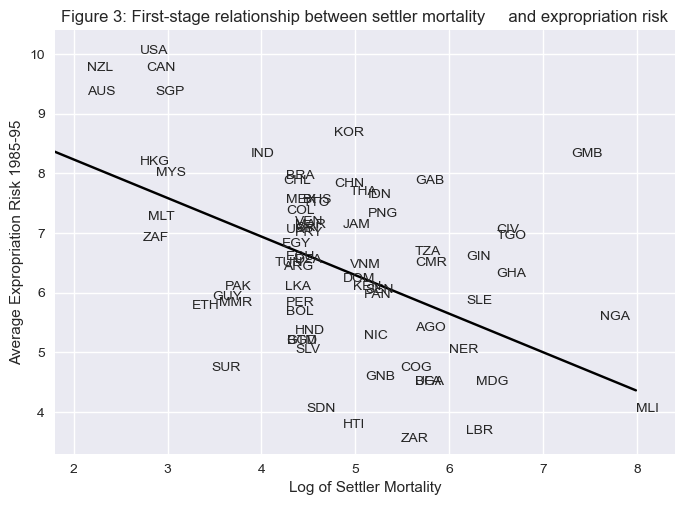

In [16]:
# Dropping NA's is required to use numpy's polyfit
df1_subset2 = df1.dropna(subset=['logem4', 'avexpr'])

X = df1_subset2['logem4']
y = df1_subset2['avexpr']
labels = df1_subset2['shortnam']

# Replace markers with country labels
fig, ax = plt.subplots()
ax.scatter(X, y, marker='')

for i, label in enumerate(labels):
    ax.annotate(label, (X.iloc[i], y.iloc[i]))

# Fit a linear trend line
ax.plot(np.unique(X),
         np.poly1d(np.polyfit(X, y, 1))(np.unique(X)),
         color='black')

ax.set_xlim([1.8,8.4])
ax.set_ylim([3.3,10.4])
ax.set_xlabel('Log of Settler Mortality')
ax.set_ylabel('Average Expropriation Risk 1985-95')
ax.set_title('Figure 3: First-stage relationship between settler mortality \
    and expropriation risk')
plt.show()

In [17]:
# Import and select the data
df4 = pd.read_stata('https://github.com/QuantEcon/lecture-python/blob/master/source/_static/lecture_specific/ols/maketable4.dta?raw=true')
df4 = df4[df4['baseco'] == 1]

# Add a constant variable
df4['const'] = 1

# Fit the first stage regression and print summary
results_fs = sm.OLS(df4['avexpr'],
                    df4[['const', 'logem4']],
                    missing='drop').fit()
print(results_fs.summary())

                            OLS Regression Results                            
Dep. Variable:                 avexpr   R-squared:                       0.270
Model:                            OLS   Adj. R-squared:                  0.258
Method:                 Least Squares   F-statistic:                     22.95
Date:                Sun, 08 Oct 2023   Prob (F-statistic):           1.08e-05
Time:                        14:28:34   Log-Likelihood:                -104.83
No. Observations:                  64   AIC:                             213.7
Df Residuals:                      62   BIC:                             218.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          9.3414      0.611     15.296      0.0

In [18]:
df4['predicted_avexpr'] = results_fs.predict()

results_ss = sm.OLS(df4['logpgp95'],
                    df4[['const', 'predicted_avexpr']]).fit()
print(results_ss.summary())

                            OLS Regression Results                            
Dep. Variable:               logpgp95   R-squared:                       0.477
Model:                            OLS   Adj. R-squared:                  0.469
Method:                 Least Squares   F-statistic:                     56.60
Date:                Sun, 08 Oct 2023   Prob (F-statistic):           2.66e-10
Time:                        14:28:35   Log-Likelihood:                -72.268
No. Observations:                  64   AIC:                             148.5
Df Residuals:                      62   BIC:                             152.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                1.9097      0.823  

In [19]:
iv = IV2SLS(dependent=df4['logpgp95'],
            exog=df4['const'],
            endog=df4['avexpr'],
            instruments=df4['logem4']).fit(cov_type='unadjusted')

print(iv.summary)

                          IV-2SLS Estimation Summary                          
Dep. Variable:               logpgp95   R-squared:                      0.1870
Estimator:                    IV-2SLS   Adj. R-squared:                 0.1739
No. Observations:                  64   F-statistic:                    37.568
Date:                Sun, Oct 08 2023   P-value (F-stat)                0.0000
Time:                        14:28:35   Distribution:                  chi2(1)
Cov. Estimator:            unadjusted                                         
                                                                              
                             Parameter Estimates                              
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
const          1.9097     1.0106     1.8897     0.0588     -0.0710      3.8903
avexpr         0.9443     0.1541     6.1293     0.00

In [20]:
# Load in data
df4 = pd.read_stata('https://github.com/QuantEcon/lecture-python/blob/master/source/_static/lecture_specific/ols/maketable4.dta?raw=true')

# Add a constant term
df4['const'] = 1

# Estimate the first stage regression
reg1 = sm.OLS(endog=df4['avexpr'],
              exog=df4[['const', 'logem4']],
              missing='drop').fit()

# Retrieve the residuals
df4['resid'] = reg1.resid

# Estimate the second stage residuals
reg2 = sm.OLS(endog=df4['logpgp95'],
              exog=df4[['const', 'avexpr', 'resid']],
              missing='drop').fit()

print(reg2.summary())

                            OLS Regression Results                            
Dep. Variable:               logpgp95   R-squared:                       0.689
Model:                            OLS   Adj. R-squared:                  0.679
Method:                 Least Squares   F-statistic:                     74.05
Date:                Sun, 08 Oct 2023   Prob (F-statistic):           1.07e-17
Time:                        14:28:35   Log-Likelihood:                -62.031
No. Observations:                  70   AIC:                             130.1
Df Residuals:                      67   BIC:                             136.8
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.4782      0.547      4.530      0.0

In [21]:
# Load in data
df1 = pd.read_stata('https://github.com/QuantEcon/lecture-python/blob/master/source/_static/lecture_specific/ols/maketable1.dta?raw=true')
df1 = df1.dropna(subset=['logpgp95', 'avexpr'])

# Add a constant term
df1['const'] = 1

# Define the X and y variables
y = np.asarray(df1['logpgp95'])
X = np.asarray(df1[['const', 'avexpr']])

# Compute β_hat
β_hat = np.linalg.solve(X.T @ X, X.T @ y)

# Print out the results from the 2 x 1 vector β_hat
print(f'β_0 = {β_hat[0]:.2}')
print(f'β_1 = {β_hat[1]:.2}')

β_0 = 4.6
β_1 = 0.53
